In [1]:
import requests 
import re
import time
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import fasttext
from sklearn import preprocessing
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

# Data Collection

Review:
- rating
- review
- displayName
- displayImageUrl
- isVerified
- isSuperReviewer
- createDate
- updateDate
- user
- score
- timeFromCreation

In [2]:
pageCount = 3000
#apiBase = "https://www.rottentomatoes.com/napi/tv/game_of_thrones/season/d4efb08e-d3c7-365e-a403-2d9095f85270/reviews/user" # S8
apiBase = 'https://www.rottentomatoes.com/napi/movie/f93fd0e2-42cf-3425-86a4-96090ed8ec13/reviews/user'
reviews = []

def getReviewPage(endCursor: str):
    page = requests.get(apiBase, params={"direction": "next", "startCursor": "", "endCursor": endCursor})
    if page.status_code != 200:
        print(f"Encountered error with web request: {page} {page.content}")
    return page.json()

def extractReview(reviewDict):
    review: str = reviewDict["review"]
    score = str(reviewDict["score"])
    review = review.lower()
    review = re.sub(r"[^\w\s]", "", review) # Remove all punctuation / non word characters
    review = re.sub(r"[\n\r\t\f\v]+|(  )+", " ", review) # Replace all whitespace with a single space
    if re.match("[^ A-z0-9]", review) != None: # If any non English characters/spaces are found at this point
        return None
    return (score, review)


START = time.time()
endCursor = ""
for i in range(pageCount):
    page = getReviewPage(endCursor)
    reviews.extend([extractReview(review) for review in page["reviews"]])
    endCursor = page["pageInfo"]["endCursor"]
    if not page["pageInfo"]["hasNextPage"]:
        print(f"Stopping at page {i + 1}, no more pages.")
        break
END = time.time()

print(f"Processed {len(reviews)} reviews in {round(END - START, 3)} seconds.")

Encountered error with web request: <Response [403]> b'<HTML><HEAD>\n<TITLE>Access Denied</TITLE>\n</HEAD><BODY>\n<H1>Access Denied</H1>\n \nYou don\'t have permission to access "http&#58;&#47;&#47;www&#46;rottentomatoes&#46;com&#47;napi&#47;movie&#47;f93fd0e2&#45;42cf&#45;3425&#45;86a4&#45;96090ed8ec13&#47;reviews&#47;user&#63;" on this server.<P>\nReference&#32;&#35;18&#46;56472317&#46;1638376593&#46;294f5b4\n</BODY>\n</HTML>\n'


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

GoT S8: 3389 reviews (340 pages)

Batman v Superman: 19,952 reviews in 1055.3 seconds (17m 35.3s)

## Writing reviews to file

In [49]:
with open("/home/richie/programming/data-mining-backup/project-2/fullData", "r+") as file:
    file.truncate(0)
    for review in reviews:
        if review:
            file.write("__label__" + review[0] + " " + review[1] + "\n")

## Finding invalid lines

In [41]:
with open("/home/richie/programming/data-mining-backup/project-2/fullData edited") as file:
    lines = file.readlines()

    for i in range(len(lines)): 
        parts = lines[i].split(" ", maxsplit=3)
        #if parts[0].find("__label__") < 0 or len(parts) < 3:
        if parts[0].find("__label__") < 0:
            print(f"Invalid line: {i + 1}")

## Finding non-English and empty lines

In [58]:
with open("/home/richie/programming/data-mining-backup/project-2/fullData edited") as file:
    lines = file.readlines()
    count = 0

    for i in range(len(lines)): 
        text = " ".join(lines[i].split(" ")[1:])
        if re.search(r"[^ A-z0-9\n]", text) or len(text) < 3:
            count += 1
            print(f"Invalid line: {i + 1}\n{text}")

    print(f"Number of invalid lines: {count}")

Number of invalid lines: 0


## Removing non-English and empty lines

In [57]:
with open("/home/richie/programming/data-mining-backup/project-2/fullData edited", "r+") as file:
    count = 0
    lines = file.readlines()
    file.seek(0)
    for line in lines:
        text = " ".join(line.split(" ")[1:])
        if not re.search(r"[^ A-z0-9\n]", text) and len(text) > 2:
            file.write(line)
        else:
            count += 1
    
    file.truncate()
    print(f"Lines removed: {count}")

Lines removed: 0


## Removing Stopwords

In [7]:
stops =  stopwords.words("english")

for stop in stops:
    if "'" in stop:
        stops.append(stop.replace("'", ""))

#print(stops)
i = 0

with open("/home/richie/programming/data-mining-backup/project-2/fullData final") as oldFile:
    with open("/home/richie/programming/data-mining-backup/project-2/fullData final2", "r+") as newFile:
        newFile.truncate()
        for oldLine in oldFile:
            words = oldLine.split(" ")
            filtered = [word for word in words if not word in stops]
            newFile.write(" ".join(filtered))

## Splitting into Train and Test data

In [8]:
trainRatio = 0.75

with open("/home/richie/programming/data-mining-backup/project-2/fullData final2") as fullData:
    lines = fullData.readlines()
    length = len(lines)
    split = round(length * trainRatio)
    
    with open("/home/richie/programming/data-mining-backup/project-2/trainData", "r+") as trainData:
        trainData.truncate()
        for i in range(split):
            trainData.write(lines[i])
    with open("/home/richie/programming/data-mining-backup/project-2/testData", "r+") as testData:
        testData.truncate()
        for i in range(split, length):
            testData.write(lines[i])

# Model Training
The following arguments for training are optional:
  - lr:                 learning rate [0.1]
  - lrUpdateRate:       change the rate of updates for the learning rate [100]
  - dim:                size of word vectors [100]
  - ws:                 size of the context window [5]
  - epoch:              number of epochs [5]
  - neg:                number of negatives sampled [5]
  - loss:               loss function {ns, hs, softmax} [softmax]
  - thread:             number of threads [12]
  - pretrainedVectors:  pretrained word vectors for supervised learning []
  - saveOutput:         whether output params should be saved [0]

In [44]:
START = time.time()
model = fasttext.train_supervised("/home/richie/programming/data-mining-backup/project-2/trainData", epoch=50, lr=1, lrUpdateRate=10, wordNgrams=2)
#fasttext.train_supervised("/home/richie/programming/data-mining-backup/project-2/trainData")
END = time.time()
print(f"Finished training in {round(END - START, 2)} seconds.")

Read 0M words
Number of words:  26474
Number of labels: 10


Finished training in 4.04 seconds.


Progress: 100.0% words/sec/thread:  812521 lr:  0.000000 avg.loss:  0.255590 ETA:   0h 0m 0s


In [150]:
# See label distribution
trainLabels = {}
total = 0
for label in model.get_labels():
    trainLabels[label] = 0

with open("/home/richie/programming/data-mining-backup/project-2/trainData") as file:
    for line in file:
        label = line.split(" ", maxsplit=1)[0]
        trainLabels[label] += 1
        total += 1
        
for label, count in trainLabels.items():
    print(f"{label}: {round(count/total * 100, 2)}%")

__label__5: 28.64%
__label__4: 15.27%
__label__3: 8.37%
__label__3.5: 8.06%
__label__0.5: 7.86%
__label__2: 7.74%
__label__4.5: 7.68%
__label__1: 6.28%
__label__2.5: 6.02%
__label__1.5: 4.08%


## Testing Model

In [77]:
results = []

with open("/home/richie/programming/data-mining-backup/project-2/testData") as testData:
    for line in testData:
        #line = testData.readline()
        parts = line.split(" ")
        label, review = parts[0], " ".join(parts[1:]).replace("\n", "")
        predicted = model.predict(review)
        results.append((label, predicted[0][0]))
        #print(label, predicted[0][0])

total = len(results)
correct = 0
halfOff = 0
oneOff = 0
other = 0

for result in results:
    diff = abs(float(result[0][9:]) - float(result[1][9:]))
    if result[0] == result[1]:
        correct += 1
    elif diff <= 0.5:  
        halfOff += 1
    elif diff <= 1.0:
        oneOff += 1
    else:
        other += 1

output = f"Total: {total}\nCorrect: {correct} ({round(correct/total * 100, 2)}%)\n" + \
    f"Within 0.5: {halfOff} ({round(halfOff/total * 100, 2)}%) ({round((halfOff + correct)/total * 100, 2)}% Total)"+ \
    f"\nWithin 1.0: {oneOff} ({round(oneOff/total * 100, 2)}%) ({round((oneOff + halfOff + correct)/total * 100, 2)}% Total)" + \
    f"\nOutside 1.0:  {other} ({round(other/total * 100, 2)}%)"
print(output)

Total: 4833
Correct: 1813 (37.51%)
Within 0.5: 1235 (25.55%) (63.07% Total)
Within 1.0: 999 (20.67%) (83.74% Total)
Outside 1.0:  786 (16.26%)


In [152]:
# See label distribution
testLabels = {}
total = 0
for label in model.get_labels():
    testLabels[label] = 0

with open("/home/richie/programming/data-mining-backup/project-2/testData") as file:
    for line in file:
        label = line.split(" ", maxsplit=1)[0]
        testLabels[label] += 1
        total += 1
        
for label, count in testLabels.items():
    print(f"{label}: {round(count/total * 100, 2)}%")

__label__5: 35.28%
__label__4: 17.03%
__label__3: 6.85%
__label__3.5: 7.1%
__label__0.5: 5.26%
__label__2: 6.29%
__label__4.5: 9.93%
__label__1: 4.26%
__label__2.5: 4.8%
__label__1.5: 3.21%


## Visualizations

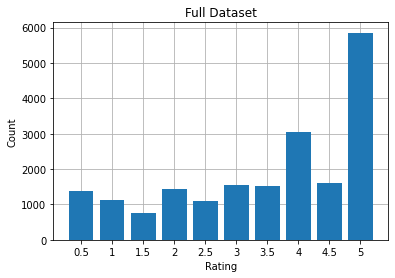

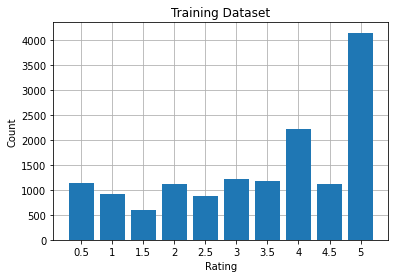

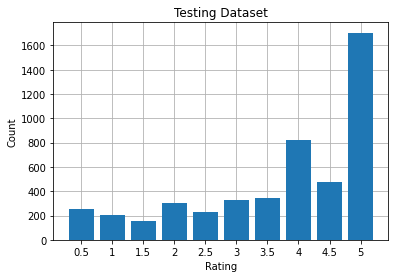

In [76]:
def getReviews(filePath):
    labels = {}
    with open(filePath) as file:
        for line in file.readlines():
            parts = line.split(" ", maxsplit=1)
            label = parts[0].replace("__label__", "")
        
            if not labels.get(label):
                labels[label] = 1
            else:
                labels[label] += 1

    return labels

def graphReviews(reviews, title):
    keys = list(reviews.keys())
    keys.sort()
    values = [reviews[key] for key in keys]

    plt.grid(zorder=0)
    plt.bar(keys, values, zorder=2)
    plt.ylabel("Count")
    plt.xlabel("Rating")
    plt.title(title)
    plt.show()

graphReviews(getReviews("/home/richie/programming/data-mining-backup/project-2/fullData final2"), "Full Dataset")
graphReviews(getReviews("/home/richie/programming/data-mining-backup/project-2/trainData"), "Training Dataset")
graphReviews(getReviews("/home/richie/programming/data-mining-backup/project-2/testData"), "Testing Dataset")

{'0.5': {'0.5': 85, '1': 59, '1.5': 19, '2': 47, '2.5': 15, '3': 23, '3.5': 6, '4': 8, '4.5': 2, '5': 10}, '1': {'0.5': 50, '1': 35, '1.5': 29, '2': 39, '2.5': 19, '3': 9, '3.5': 2, '4': 3, '4.5': 3, '5': 7}, '1.5': {'0.5': 16, '1': 22, '1.5': 17, '2': 19, '2.5': 16, '3': 2, '3.5': 7, '4': 8, '4.5': 5, '5': 1}, '2': {'0.5': 41, '1': 36, '1.5': 23, '2': 64, '2.5': 37, '3': 35, '3.5': 18, '4': 13, '4.5': 8, '5': 12}, '2.5': {'0.5': 13, '1': 23, '1.5': 26, '2': 55, '2.5': 40, '3': 43, '3.5': 18, '4': 17, '4.5': 6, '5': 15}, '3': {'0.5': 16, '1': 9, '1.5': 17, '2': 33, '2.5': 43, '3': 66, '3.5': 45, '4': 59, '4.5': 18, '5': 42}, '3.5': {'0.5': 6, '1': 7, '1.5': 7, '2': 15, '2.5': 26, '3': 38, '3.5': 48, '4': 80, '4.5': 29, '5': 71}, '4': {'0.5': 7, '1': 2, '1.5': 7, '2': 9, '2.5': 12, '3': 68, '3.5': 105, '4': 266, '4.5': 127, '5': 253}, '4.5': {'0.5': 1, '1': 0, '1.5': 1, '2': 5, '2.5': 7, '3': 11, '3.5': 33, '4': 76, '4.5': 43, '5': 145}, '5': {'0.5': 19, '1': 13, '1.5': 9, '2': 18, '2.5

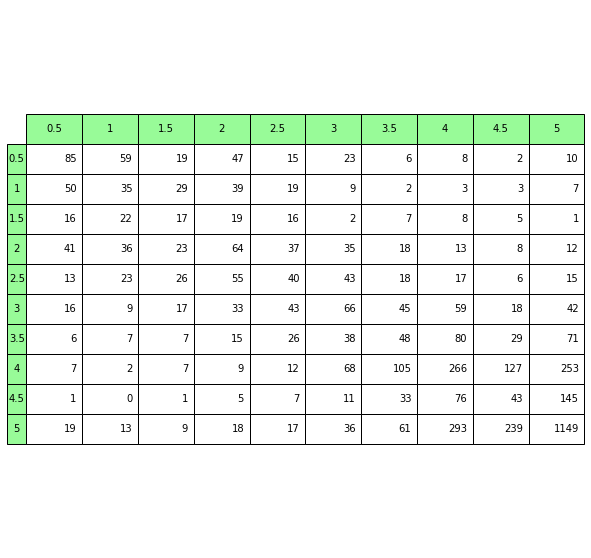

In [115]:
def convertLabel(label):
    return label.replace("__label__", "")

# Prediction accuracy plot
labels = ["0.5", "1", "1.5", "2", "2.5", "3", "3.5", "4", "4.5", "5"]
dataDict = {predictedLabel:{actualLabel:0 for actualLabel in labels} for predictedLabel in labels}
data = [[0] * len(labels) for i in range(len(labels))]

def getLabelIndex(label):
    return labels.index(label)

for result in results:
    dataDict[convertLabel(result[1])][convertLabel(result[0])] += 1
    actual = convertLabel(result[0])
    predicted = convertLabel(result[1])
    data[getLabelIndex(predicted)][getLabelIndex(actual)] += 1

#print(dataDict)
#print(data)

fig, ax = plt.subplots()
ax.set_axis_off()
table = ax.table(cellText=data, rowLabels=labels, colLabels=labels, rowColours=["palegreen"] * 10, colColours=["palegreen"] * 10, loc="center", rowLoc="center", colLoc="center")
fig.set_figwidth(10)
fig.set_figheight(10)
